In [1]:
#autoreload 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import lightning as lt
import yaml
from models.CNNAE import AE
import matplotlib.pyplot as plt

ckpt_path = "/home/npopkov/vesuvius_gcml/notebooks/encoder_ckpt/"

encoder_path = ckpt_path + "encoder.pth"
attention_path = ckpt_path + "attention.pth"

aae = AE()
aae.encoder.load_state_dict(torch.load(encoder_path))
aae.attention.load_state_dict(torch.load(attention_path))

encoder = aae.encoder
attention = aae.attention



/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from ml.inklabel_dataset import InkLabelDataset
segment_ids = yaml.safe_load(open('../configs/segment_ids.yaml', 'r'))
print(segment_ids['segment_ids'])
segments = [segment_ids['segment_ids']['segments'][0]]
SAMPLE_SIZE = 32
dataset = InkLabelDataset(segment_ids=segments,sample_size=SAMPLE_SIZE)
train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_Loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True,num_workers=27)
test_Loader = torch.utils.data.DataLoader(test, batch_size=16, shuffle=False,num_workers=27)
validation_Loader = torch.utils.data.DataLoader(val, batch_size=16, shuffle=False,num_workers=27)

{'segments': ['20231210121321', '20231106155350', '20231005123336', '20230820203112', '20230620230619', '20230826170124', '20230702185753', '20230522215721', '20230531193658', '20230520175435', '20230903193206', '20230902141231', '20231007101615', '20230929220924', 'recto', 'verso', '20231016151000', '20231012184423', '20231031143850']}
Creating InkLabelDataset with 1 segments...


In [ ]:
trainer = lt.Trainer(max_epochs=500, accelerator="gpu", devices=1, callbacks=[lt.pytorch.callbacks.early_stopping.EarlyStopping(monitor="train_loss", patience=15, mode="min")])
    

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/npopkov/vesuvius_gcml/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


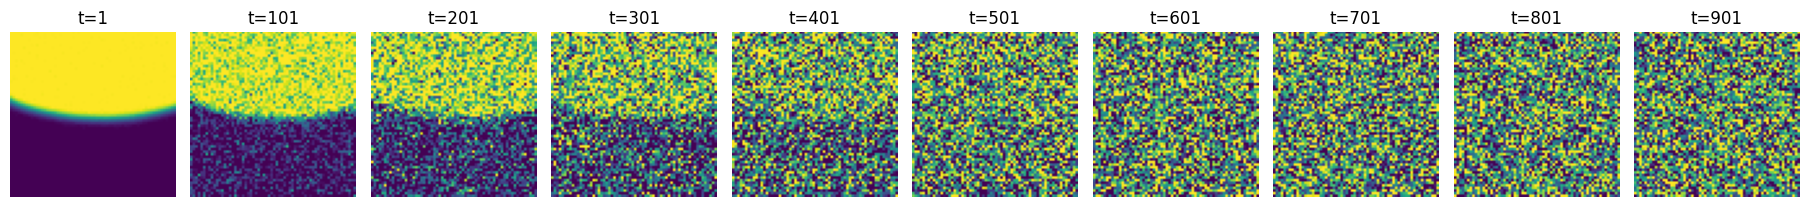

In [ ]:
from models.condDDPM import Diffusion

ddpm = Diffusion(
    noise_steps=1000,
    beta_start=1e-4,
    beta_end=0.03,
    img_size=SAMPLE_SIZE,
    c_in=1,
    c_out=1,
    encoder=encoder,
    attention=attention
)

ddpm.plot_test_noising(x=next(iter(train_Loader))['ink_label'][0].float().cuda())

In [ ]:
trainer.fit(ddpm, train_Loader, validation_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | UNet_conditional | 16.5 M | train
1 | ema_model | UNet_conditional | 16.5 M | eval 
-------------------------------------------------------
16.5 M    Trainable params
16.5 M    Non-trainable params
32.9 M    Total params
131.662   Total estimated model params size (MB)
197       Modules in train mode
283       Modules in eval mode


RuntimeError: The size of tensor a (16) must match the size of tensor b (64) at non-singleton dimension 0

In [ ]:
ddpm.save(model_cpkt_path="/home/npopkov/vesuvius_gcml/notebooks/ddpm_ckpt", model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt")

In [ ]:
ddpm.load(model_cpkt_path="/home/npopkov/vesuvius_gcml/notebooks/ddpm_ckpt", model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt")

Output shape after training: torch.Size([16, 1, 32, 32])


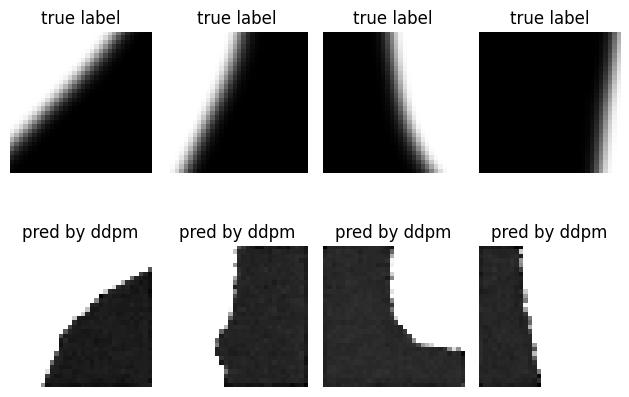

In [ ]:
test_sample = next(iter(test_Loader))

test_results = ddpm.__test_after_training__(test_sample['scroll_segment'].float().cuda())


for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(test_sample['ink_label'][i].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("true label")

    plt.subplot(2, 4, i + 5)
    plt.imshow(test_results[i][0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("pred by ddpm")
plt.tight_layout()
plt.show()